In [2]:
import pandas as pd
import pandahouse as ph
import scipy.stats as stats
import seaborn as sns
import numpy as np
import karpov_secrets as ks

In [3]:
#параметры соединения
connection = ks.connection

# А\А тест

In [4]:
#текст запроса
query = '''
select user_id, exp_group,
countIf(action = 'view') as views,
countIf(action = 'like') as likes,
likes/views as ctr
from {db}.feed_actions
where (toDate(time) between '2023-07-23' and '2023-07-29') and (exp_group in (2,3))
group by user_id, exp_group
'''

# эта функция выполнит запрос и запишет его результат в pandas DataFrame
df = ph.read_clickhouse(query, connection=connection)

In [5]:
df.head()

,user_id,exp_group,views,likes,ctr
0,115383,3,248,38,0.153226
1,10326,3,132,24,0.181818
2,123580,3,122,25,0.204918
3,131473,2,98,19,0.193878
4,23985,2,44,12,0.272727


In [5]:
df.exp_group.value_counts()

exp_group
3    8425
2    8362
Name: count, dtype: int64

In [6]:
np.random.seed(seed=499)
sample_size = 500
N = 10000
p_values=[]
for _ in range(N):
    p = stats.ttest_ind(df[df.exp_group==2].ctr.sample(sample_size),
                df[df.exp_group==3].ctr.sample(sample_size),
                equal_var=False)[1]
    
    p_values.append(p)

( pd.Series(p_values) <= 0.05 ).mean()

0.0447

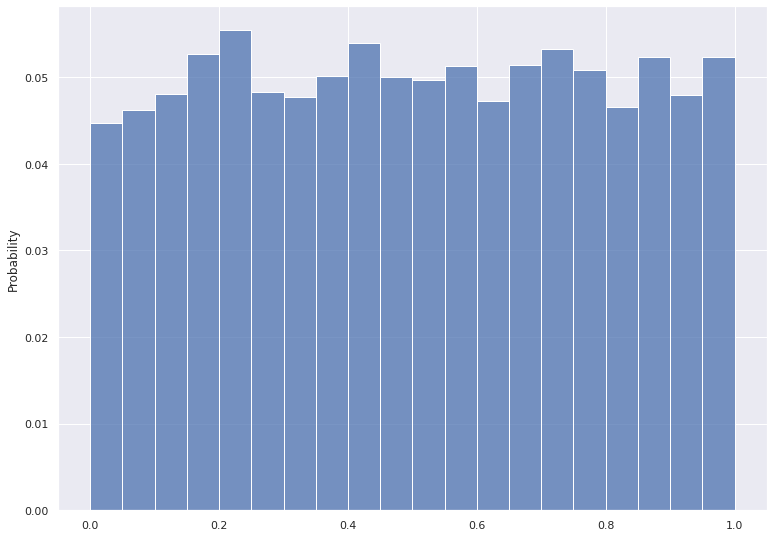

In [12]:
sns.set(rc={'figure.figsize':(12.7,9.27)})

groups = sns.histplot(p_values, bins=20, stat='probability', kde=False)

4.47% значений p-value оказались меньше 0.05, то есть полученный уроень ошибки первого рода меньше заданного порога. Распределние p-value равномерное (хотя нам конечно важнее как оно ведет себя возле 0). Вобщем система сплитования работает нормально

# А\Б тест

In [13]:
query_ab = '''
select user_id, exp_group,
countIf(action = 'view') as views,
countIf(action = 'like') as likes,
likes/views as ctr
from {db}.feed_actions
where (toDate(time) between '2023-07-30' and '2023-08-05') and (exp_group in (1,2))
group by user_id, exp_group
'''

# эта функция выполнит запрос и запишет его результат в pandas DataFrame
df_ab = ph.read_clickhouse(query_ab, connection=connection)

In [14]:
df_ab.head()

,user_id,exp_group,views,likes,ctr
0,109963,1,15,3,0.200000
1,26117,1,141,32,0.226950
2,138232,1,73,18,0.246575
3,18392,1,32,7,0.218750
4,26295,1,141,39,0.276596


In [15]:
df_ab.exp_group.value_counts()

exp_group
1    10020
2     9877
Name: count, dtype: int64

<Axes: xlabel='ctr', ylabel='Count'>

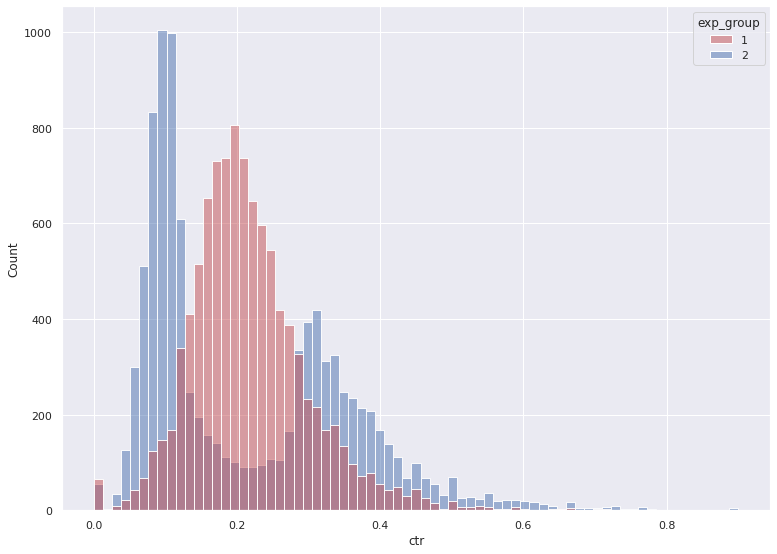

In [16]:
sns.histplot(data = df_ab, 
              x='ctr', 
              hue='exp_group', 
              palette = ['r', 'b'],
              alpha=0.5,
              kde=False)

In [17]:
df_ab.groupby(df_ab.exp_group).ctr.mean()

exp_group
1    0.216774
2    0.216102
Name: ctr, dtype: float64

### t-test

In [18]:
stats.ttest_ind(df_ab[df_ab.exp_group==1].ctr,
                df_ab[df_ab.exp_group==2].ctr,
                equal_var=False)

Ttest_indResult(statistic=0.4051491913112757, pvalue=0.685373331140751)

p-value=0.68, что гораздо выше 0.05, значит у нас недостаточно оснований для отклонения нулевой гипотезы о равенстве средних.

Проблема в том, что распределение ctr юзеров с новым алгоритмом бимодальное (далеко от нормального), а значит t-test применять нельзя (как я думаю из-за того, что он неправильно оценивает дисперсию, завышая ее, и не может различить средние ctr, отличающиеся в 4 знаке после запятой )

### тест Манна-Уитни

In [19]:
stats.mannwhitneyu(df_ab[df_ab.exp_group==1].ctr,
                df_ab[df_ab.exp_group==2].ctr)

MannwhitneyuResult(statistic=55189913.0, pvalue=4.632205841806026e-45)

p-value практически равно 0, значит наша тестовая выборка с новым алгоритмом стат значимо отличается от конрольной по признаку ctr при a=0.05

Собственно, это было видно на гистограмме ctr - отличие распределений (а значит и выборок) видно невооруженным глазом

### Пуассоновский бутстрап

In [20]:
def bootstrap(likes1, views1, likes2, views2, n_bootstrap=2000):

    poisson_bootstraps1 = stats.poisson(1).rvs(
        (n_bootstrap, len(likes1))).astype(np.int64)

    poisson_bootstraps2 = stats.poisson(1).rvs(
            (n_bootstrap, len(likes2))).astype(np.int64)
    
    globalCTR1 = (poisson_bootstraps1*likes1).sum(axis=1)/(poisson_bootstraps1*views1).sum(axis=1)
    
    globalCTR2 = (poisson_bootstraps2*likes2).sum(axis=1)/(poisson_bootstraps2*views2).sum(axis=1)

    return globalCTR1, globalCTR2

<Axes: ylabel='Count'>

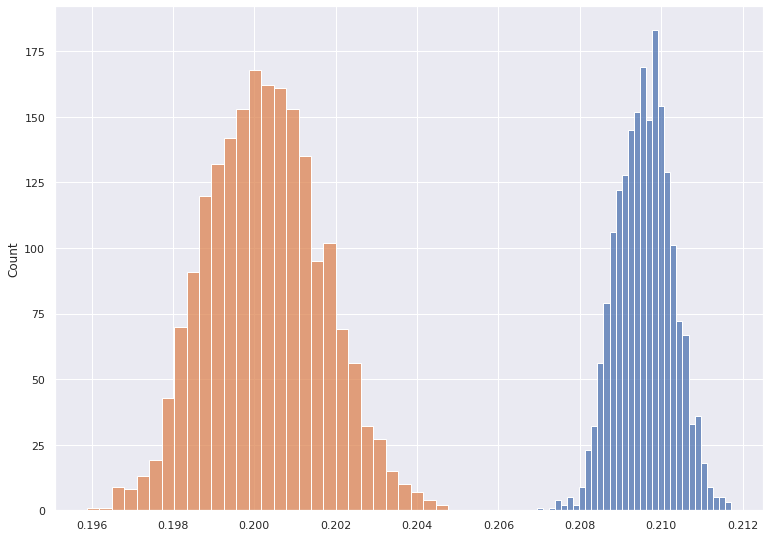

In [21]:
likes1 = df_ab[df_ab.exp_group == 1].likes.to_numpy()
views1 = df_ab[df_ab.exp_group == 1].views.to_numpy()
likes2 = df_ab[df_ab.exp_group == 2].likes.to_numpy()
views2 = df_ab[df_ab.exp_group == 2].views.to_numpy()

np.random.seed(499)
ctr1, ctr2 = bootstrap(likes1, views1, likes2, views2)

sns.histplot(ctr1)
sns.histplot(ctr2)

[-0.01223609 -0.00621085] -0.009332538249236478


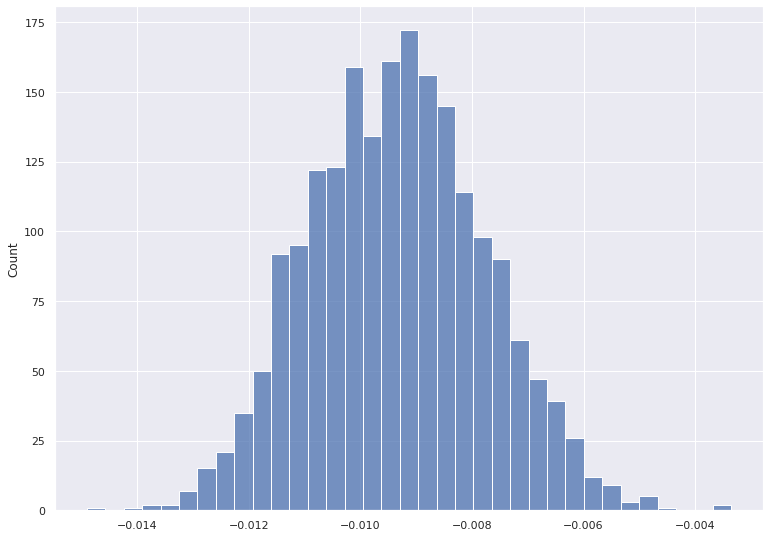

In [22]:
#Разница между глобальными CTR

sns.histplot(ctr2 - ctr1)
print(np.quantile(ctr2 - ctr1, [0.025, 0.975]), np.mean(ctr2 - ctr1))

In [23]:
global_ctr_1 = df_ab[df_ab.exp_group == 1].likes.sum()/df_ab[df_ab.exp_group == 1].views.sum()
global_ctr_2 = df_ab[df_ab.exp_group == 2].likes.sum()/df_ab[df_ab.exp_group == 2].views.sum()
print(global_ctr_1, global_ctr_2)

0.2096041628394293 0.20025051027061783


Бутстрап позволил получить распределение для глобального CTR, которое согласно ЦПТ приобрело нормальную форму. Вычтя полученные выборки, мы получили распределение для разниц между глобальными CTR с 95% доверитльеным интервалом [-0.012, -0.006] и средним -0.009. Доверительный интервал не включает 0 и указывает на то, что в среднем CTR в контрольной группе выше, чем в тестовой на 0.009 (4.5% от тестового ctr); то есть новым алгоритмом мы понизили общую вовлеченность пользователей

### Сглаженный CTR

In [24]:
def get_smothed_ctr(user_likes, user_views, global_ctr, alpha):
    smothed_ctr = (user_likes + alpha * global_ctr) / (user_views + alpha)
    return smothed_ctr

In [25]:
group1 = df_ab[df_ab.exp_group == 1].copy()
group2 = df_ab[df_ab.exp_group == 2].copy()

<Axes: xlabel='smothed_ctr', ylabel='Count'>

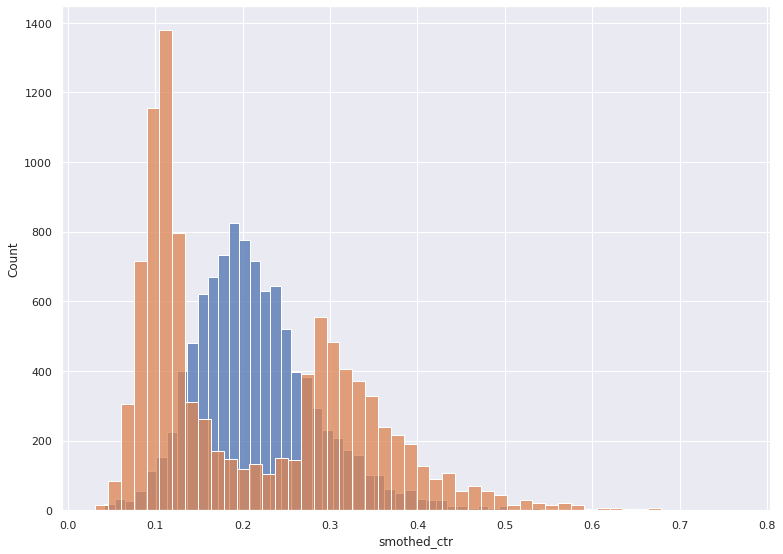

In [26]:
group1['smothed_ctr'] = df_ab.apply(
    lambda x: get_smothed_ctr(x['likes'], x['views'], global_ctr_1, 5), axis=1)
group2['smothed_ctr'] = df_ab.apply(
    lambda x: get_smothed_ctr(x['likes'], x['views'], global_ctr_2, 5), axis=1)


sns.histplot(group1.smothed_ctr, bins=50,
             kde = False)
sns.histplot(group2.smothed_ctr, bins=50,
             kde = False)

In [27]:
stats.ttest_ind(group1['smothed_ctr'],
                group2['smothed_ctr'],
                equal_var=False)

Ttest_indResult(statistic=1.9460491517027683, pvalue=0.05166679015318526)

In [28]:
print(group1['smothed_ctr'].mean(), group2['smothed_ctr'].mean())
print(global_ctr_1, global_ctr_2)

0.21527988017565183 0.21250810594606076
0.2096041628394293 0.20025051027061783


CTR был 0.2167 и 0.2161, сглаженный стал 0.2152 и 0.2125 CTR в контроле и тесте соотвественно, то есть сглаживание как бы растащило средние CTR дальше друг от друга, что практически позволило t-test'у заметить разницу в средних (p-value=0.051). С другой стороны это никак не повлияло на бимодальную форму распределения тестовго CTR, так что результаты t-test все равно нельзя было бы использовать для принятия решения о выкатке нового алгортима

### Бакетное преобразование

In [29]:
q_backet = """

SELECT exp_group, bucket,
    sum(likes)/sum(views) as bucket_ctr,
    quantileExact(0.9)(ctr) as ctr9
FROM (SELECT exp_group, 
        xxHash64(user_id)%50 as bucket,
        user_id,
        sum(action = 'like') as likes,
        sum(action = 'view') as views,
        likes/views as ctr
    FROM {db}.feed_actions 
    WHERE (toDate(time) between '2023-07-30' and '2023-08-05') and (exp_group in (1,2))
    GROUP BY exp_group, bucket, user_id)
GROUP BY exp_group, bucket
"""

df_backet = ph.read_clickhouse(q_backet, connection=connection)

In [30]:
stats.mannwhitneyu(df_backet[df_backet.exp_group == 1].bucket_ctr, 
                   df_backet[df_backet.exp_group == 2].bucket_ctr, 
                   alternative = 'two-sided')

MannwhitneyuResult(statistic=1997.0, pvalue=2.6576427804010095e-07)

In [31]:
stats.ttest_ind(df_backet[df_backet.exp_group == 1].bucket_ctr, 
                   df_backet[df_backet.exp_group == 2].bucket_ctr, 
                   equal_var = False)

Ttest_indResult(statistic=5.614819358149381, pvalue=4.592644937473873e-07)

<Axes: xlabel='bucket_ctr', ylabel='Count'>

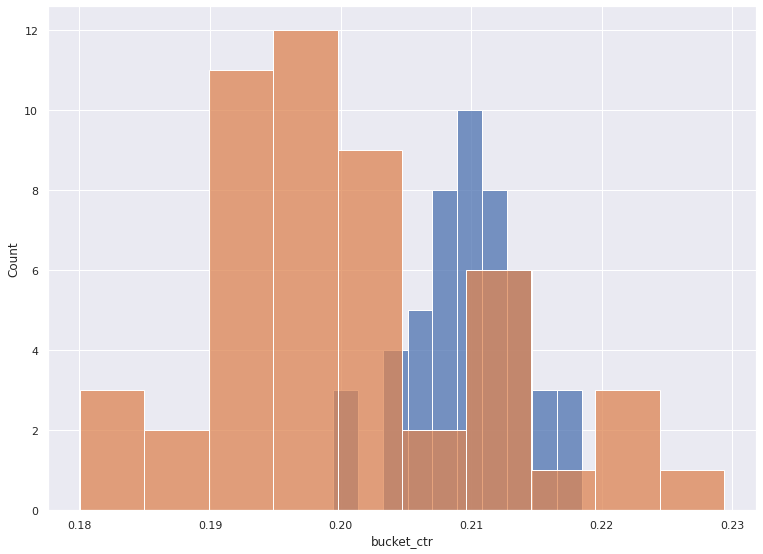

In [32]:
sns.histplot(df_backet[df_backet.exp_group == 1].bucket_ctr, bins=10)
sns.histplot(df_backet[df_backet.exp_group == 2].bucket_ctr, bins=10)

<Axes: xlabel='ctr9', ylabel='Count'>

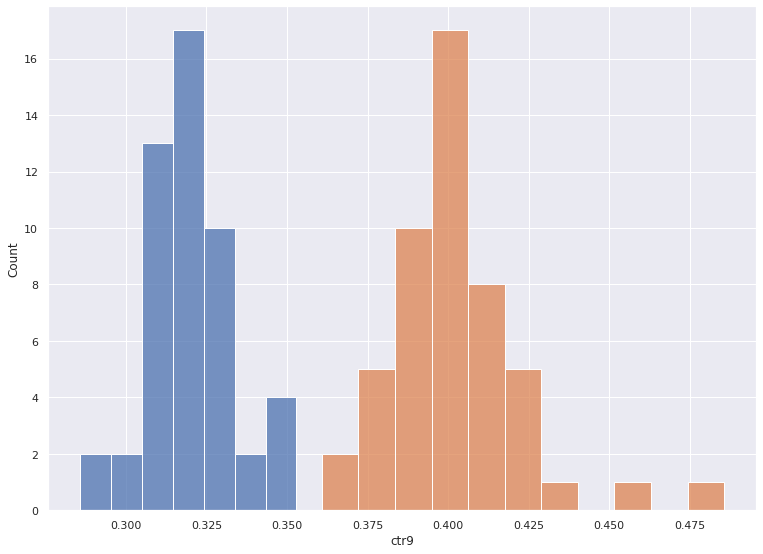

In [33]:
sns.histplot(df_backet[df_backet.exp_group == 1].ctr9)
sns.histplot(df_backet[df_backet.exp_group == 2].ctr9)

Бакетное преобразование +/- нормализовало распределение среднего ctr для тестовой группы - для каждого бакета среднее значение получалось где-то между двумя 'горбами' изначального распределения. И Манна-Уитни, и t-тест заметили стат значимое различие между выборками с p-value < 0.05.

90-ый перцентиль, рассчитанный для тестовой группы по сути является отображением правого 'горба распределения', так как практически для каждого бакета выбор 90 перцентиля означал выбор значения метрики около правой моды. Можно сказать, что мы значимо улучшили вовлеченность топовый перцентилей, но, аналогично, ухудшили ctr низких перцентилей

### Вывод

После введения нового алгоритма, получившие его пользователи разделились на 2 группы - те кому понравился новый алгоритм, то есть им стали больше нравится рекомендуемые посты, и те, для кого новые реомендации стали неинтересными - отсюда бимодальное распределение CTR в тестовой группе.

Я бы не стал раскатывать новый алгоритм на всех новых пользователей - глобальный CTR упал по сравнению с контрольной группой, то есть общая вовлеченность в продукт упала примерно на 4% и скорее всего метрика прибыли от нашего продукта также упадет. Во-вторых, юзеры с низким CTR могут покинуть наше приложение из-за плохий рекомендаций

# Линеаризация

### Для групп 1 и 2

In [34]:
df_ab['linearized_likes'] = df_ab.likes - global_ctr_1*df_ab.views

In [35]:
df_ab.groupby(df_ab.exp_group).linearized_likes.mean()

exp_group
1   -2.696446e-16
2   -6.245119e-01
Name: linearized_likes, dtype: float64

In [36]:
stats.ttest_ind(df_ab[df_ab.exp_group==1].linearized_likes,
                df_ab[df_ab.exp_group==2].linearized_likes,
                equal_var=False)

Ttest_indResult(statistic=5.93637710193448, pvalue=2.9805064038668164e-09)

<Axes: xlabel='linearized_likes', ylabel='Count'>

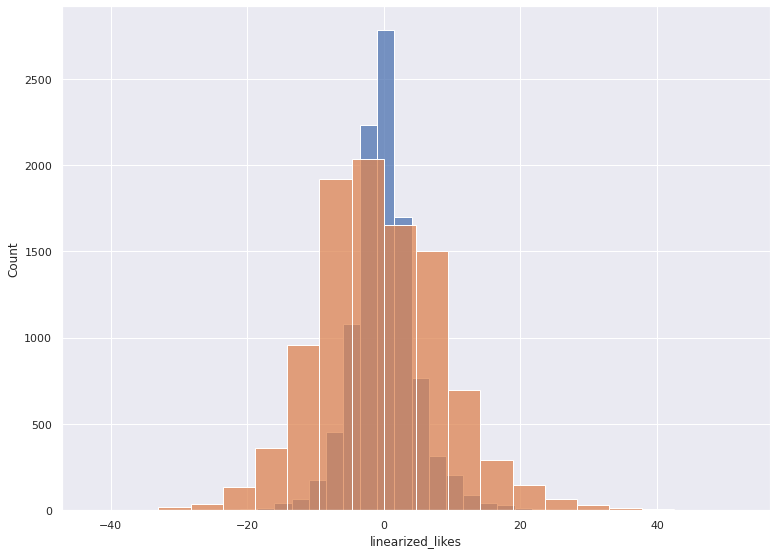

In [37]:
sns.histplot(df_ab[df_ab.exp_group == 1].linearized_likes, bins=20)
sns.histplot(df_ab[df_ab.exp_group == 2].linearized_likes, bins=20)

Линеаризация повысила чувствительность метрики, p-value t-теста оказался наименьшим из всех выше проведенных (обычным, сглаженным, бакетным) и гораздо меньше 0. Сохранилась направленность изменения метрики - контрольный CTR больше тестового и даже распределение новой лин. метрики оказалось номальным на вид для 2 группы (если поставить bins=20)

### Для 0 и 3

In [38]:
query_lin = '''
WITH (
select countIf(action = 'like') / countIf(action = 'view')
from simulator_20230820.feed_actions
where (toDate(time) between '2023-07-30' and '2023-08-05') and (exp_group =0)
) as ctr_control

select user_id, exp_group,
countIf(action = 'like') - ctr_control*countIf(action = 'view') as linearized_likes,
countIf(action = 'like') / countIf(action = 'view') as ctr
from simulator_20230820.feed_actions
where (toDate(time) between '2023-07-30' and '2023-08-05') and (exp_group in (0,3))
group by user_id, exp_group
'''

# эта функция выполнит запрос и запишет его результат в pandas DataFrame
df_lin = ph.read_clickhouse(query_lin, connection=connection)

In [39]:
stats.ttest_ind(df_lin[df_lin.exp_group==0].ctr,
                df_lin[df_lin.exp_group==3].ctr,
                equal_var=False)

Ttest_indResult(statistic=-13.935320516755773, pvalue=6.216047483062228e-44)

In [40]:
stats.ttest_ind(df_lin[df_lin.exp_group==0].linearized_likes,
                df_lin[df_lin.exp_group==3].linearized_likes,
                equal_var=False)

Ttest_indResult(statistic=-16.186230032932844, pvalue=1.4918137745326139e-58)

<Axes: xlabel='ctr', ylabel='Count'>

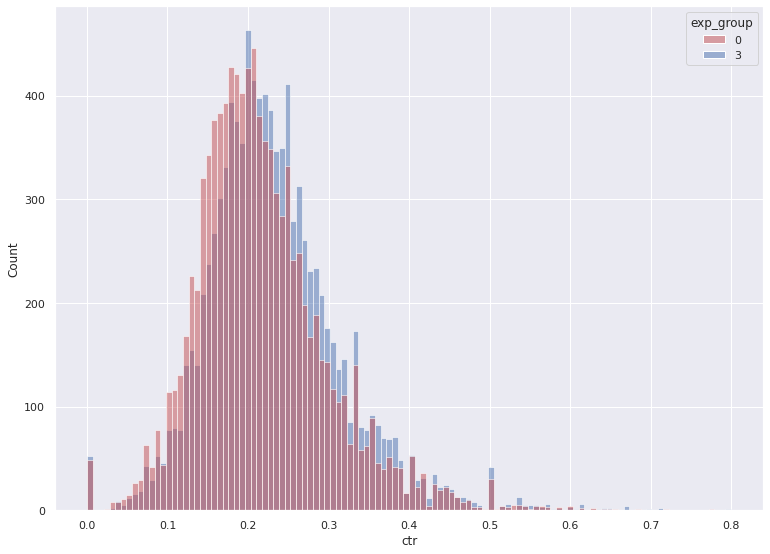

In [41]:
sns.histplot(data = df_lin, 
              x='ctr', 
              hue='exp_group', 
              palette = ['r', 'b'],
              alpha=0.5,
              kde=False)

<Axes: xlabel='linearized_likes', ylabel='Count'>

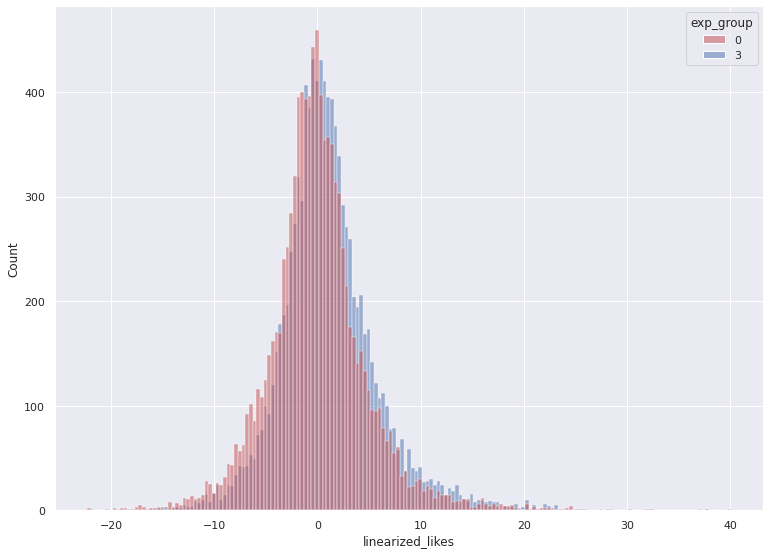

In [42]:
sns.histplot(data = df_lin, 
              x='linearized_likes', 
              hue='exp_group', 
              palette = ['r', 'b'],
              alpha=0.5,
              kde=False)

Для групп 0 и 3 линеаризация также повысила чувствительность метрики, хотя p-value и так был гораздо меньше нуля. Возможно при дизайне следующего эксперемента, будет сразу выбрана линеаризованная метрика, тогда получится ускорить А\Б тест во времени, либо проводить на меньшем кол-ве пользователей, не рискуя аудиторией, если изменение окажется ухудшающим